In [1]:
# Data science toolkit
library(tidyverse)

# Modeling
library(caret)

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.0.0     v purrr   0.2.5
v tibble  1.4.2     v dplyr   0.7.6
v tidyr   0.8.1     v stringr 1.3.1
v readr   1.1.1     v forcats 0.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Loading required package: lattice

Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift



In [4]:
# Load dataset
raw_data <- read.csv('../Data/iris.csv')

head(raw_data)

sepal_length,sepal_width,petal_length,petal_width,species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa


### Exploring the distribution of class lables given top 2 principal componenets
#### Classes are clearly linearly seperable 

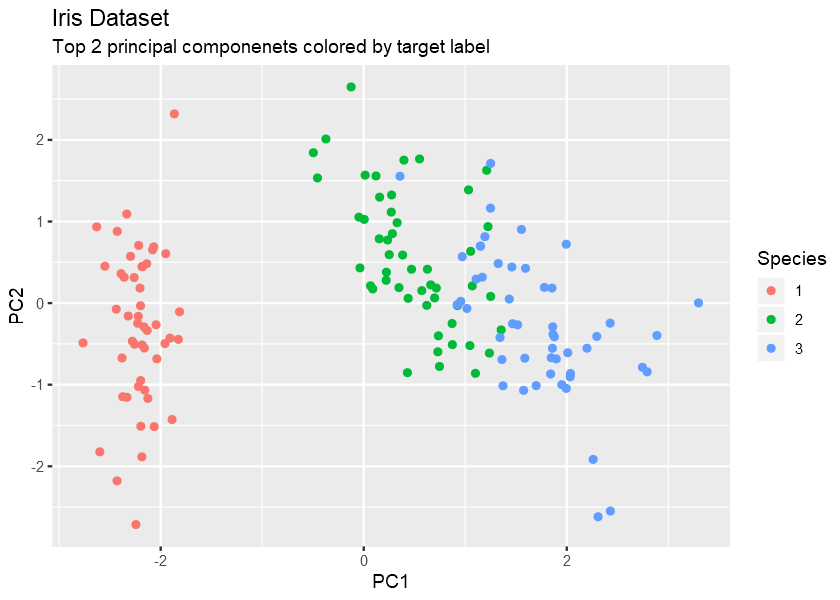

In [20]:
# Perform PCA
pca_data <- prcomp(raw_data[,1:4],center=T,scale=T)

# Append target labels
pca_target <- data.frame(cbind(pca_data$x,SPECIES=raw_data$species))

# Set plot dimensions
options(repr.plot.width=7,repr.plot.height=5)

ggplot(pca_target,aes(x=PC1,y=PC2,color=as.factor(SPECIES))) + 
    geom_point() +
    labs(title='Iris Dataset',
         subtitle='Top 2 principal componenets colored by target label',
         color='Species')